In [1]:
import joblib
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.transform import from_bounds
import os
import time
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def listFolder(path):
    folders = [os.path.join(path, name) for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]
    return folders

def listImages(path):
    imagelist = []
    for file in os.listdir(path):
        if file.endswith(".tif"):
            each_iamge_path = os.path.join(path, file)
            imagelist.append(each_iamge_path)
    return imagelist

def predictingMap(Imagelist, output, fitedRFmodel):
    
    if os.path.exists(output):
        
        print("The file already exists. Skipping creation for {}.".format(output))
        
    else:
        start = time.time()
        
        print("Now predicting and creating for {}".format(output))
        
        arrays = []

        for index, each_image_path in enumerate(Imagelist):  

            with rasterio.open(each_image_path) as src:
                
                arrays.append(src.read(1))
                
        meta = src.meta
        
        try:
            X = np.stack(arrays, axis = -1)
    
            rows, cols, bands = X.shape
    
            X_2d = X.reshape(rows*cols, bands)
    
            y_pred = fitedRFmodel.predict(X_2d) 
        
            biomass = y_pred.reshape(rows, cols)**2
    
            with rasterio.open(output, "w", **meta) as dst:
        
                dst.write(biomass,1)
        
            print("Finished Predicting and the Predicted Maps have been produced.")
            print("The process used {} mins.".format(round((time.time()-start)/60, 2)))
        except Exception as e:
            print("Error for {}".format(output))
            print({e})
            pass

In [2]:
# Ensure loading the UAV maps in the same order with the predictors in the model
# Get more details from "S1_RandomForest_estimation\RF_forage_biomass.ipynb"

predictors = ["ClGreen", "GNDVI", "MSAVI2", "NDRE", "NDVI", "RVI", "SFDVI", "PreAccmm", "GDD"]
order = {char: index for index, char in enumerate(predictors)}
print(order)

{'ClGreen': 0, 'GNDVI': 1, 'MSAVI2': 2, 'NDRE': 3, 'NDVI': 4, 'RVI': 5, 'SFDVI': 6, 'PreAccmm': 7, 'GDD': 8}


# Apply the pretained forage biomass estimation model to UAV (drone) multispectral images
#### Here we will examplfy by using the pretrained livebiomass estimation model 
#### This pretrained livebiomass estimation model is applied to the multispectral images collected on June-28, 2021

In [3]:
# Load trained livebiomass estimation model
biomasstype = "Livebiomass"
model_file = "./S1_RandomForest_estimation/Livebiomass_RF_model.joblib"
model = joblib.load(model_file)

In [4]:
# Folder of all predictors on June 28, 2021
VIs_folder = "./S2_Apply_EstimationModel_Drone_Images/UAV_VIs_2021-06-28/"
Imagelist = listImages(VIs_folder)

In [5]:
sorted_list = sorted(Imagelist, key = lambda x: order[x.split("2021-06-28_")[1].split(".")[0]])

# Double check the order of predictor UAV VIs 
sorted_list

['./S2_Apply_EstimationModel_Drone_Images/UAV_VIs_2021-06-28/2021-06-28_ClGreen.tif',
 './S2_Apply_EstimationModel_Drone_Images/UAV_VIs_2021-06-28/2021-06-28_GNDVI.tif',
 './S2_Apply_EstimationModel_Drone_Images/UAV_VIs_2021-06-28/2021-06-28_MSAVI2.tif',
 './S2_Apply_EstimationModel_Drone_Images/UAV_VIs_2021-06-28/2021-06-28_NDRE.tif',
 './S2_Apply_EstimationModel_Drone_Images/UAV_VIs_2021-06-28/2021-06-28_NDVI.tif',
 './S2_Apply_EstimationModel_Drone_Images/UAV_VIs_2021-06-28/2021-06-28_RVI.tif',
 './S2_Apply_EstimationModel_Drone_Images/UAV_VIs_2021-06-28/2021-06-28_SFDVI.tif',
 './S2_Apply_EstimationModel_Drone_Images/UAV_VIs_2021-06-28/2021-06-28_PreAccmm.tif',
 './S2_Apply_EstimationModel_Drone_Images/UAV_VIs_2021-06-28/2021-06-28_GDD.tif']

In [6]:
output_Map_name = "./S2_Apply_EstimationModel_Drone_Images/2021-06-28_predicted_livebiomass.tif"

predictingMap(sorted_list, output_Map_name, model)

Now predicting and creating for ./S2_Apply_EstimationModel_Drone_Images/2021-06-28_predicted_livebiomass.tif
Finished Predicting and the Predicted Maps have been produced.
The process used 0.3 mins.


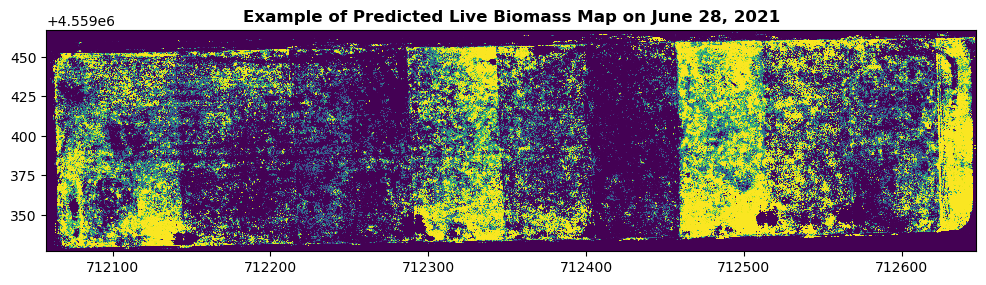

In [5]:
# Show the predicted map using rasterio
with rasterio.open(output_Map_name) as src:   

    plt.figure(figsize=(12, 10))
    
    # Display the image
    show(src, title="Example of Predicted Live Biomass Map on June 28, 2021", cmap='viridis')

plt.show() # This line is necessary to display the plot if not in an interactive environment